In [1]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt
from rasterio.mask import mask
from rasterio.features import geometry_mask
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from matplotlib.colors import ListedColormap
import fiona
import geopandas as gpd


## LULC

Read the shapefile and the bands

In [22]:
shapefile_path = "../raw-maps/Marikina Data Extracted/Marikina_Watershed_projected.shp"
dataset_path = "../raw-maps/Landsat_Bands/"
samples_path = "../raw-maps/Marikina Training Samples (20201224) - Sted/training_samples_20251109_combined_dissolved.shp"

def preprocess_band(band_path):
    path = f'{dataset_path}/{band_path}'
    gdf = gpd.read_file(shapefile_path)

    with rasterio.open(path) as src:
        if gdf.crs != src.crs:
            print("Warning: CRS Mismatch")
            gdf = gdf.to_crs(src.crs)

        shapes = [geom.__geo_interface__ for geom in gdf.geometry]
        clipped, transform = mask(src, shapes, crop=True, nodata=0)

    band_clipped = clipped[0].astype("float32")

    return band_clipped, transform

with fiona.open(shapefile_path, "r") as shapefile:
    shapes = [feature['geometry'] for feature in shapefile]

In [32]:
b1, transform = preprocess_band('LC08_L2SP_116050_20201224_20210310_02_T1_SR_B1.TIF')
b2, _ = preprocess_band('LC08_L2SP_116050_20201224_20210310_02_T1_SR_B2.TIF')
b3, _ = preprocess_band('LC08_L2SP_116050_20201224_20210310_02_T1_SR_B3.TIF')
b4, _ = preprocess_band('LC08_L2SP_116050_20201224_20210310_02_T1_SR_B4.TIF')
b5, _ = preprocess_band('LC08_L2SP_116050_20201224_20210310_02_T1_SR_B5.TIF')
b6, _ = preprocess_band('LC08_L2SP_116050_20201224_20210310_02_T1_SR_B6.TIF')
b7, _ = preprocess_band('LC08_L2SP_116050_20201224_20210310_02_T1_SR_B7.TIF')

Spectral Indices and Training

In [40]:
np.seterr(divide='ignore', invalid ='ignore')

ndvi = (b5 - b4)/(b5 + b4) 
ndvi[(b5 + b4) == 0] = np.nan

features = np.dstack((b1,b2,b3,b4,b5,b6,b7,ndvi))
X = features.reshape(-1, features.shape[-1])

gdf = gpd.read_file(samples_path)

with rasterio.open('../raw-maps/Landsat_Bands/LC08_L2SP_116050_20201224_20210310_02_T1_SR_B1.TIF') as src:
    if gdf.crs != src.crs:
        print("Warning: CRS Mismatch")
        gdf = gdf.to_crs(src.crs)


In [48]:
training_shapes = gdf.geometry
training_labels = gdf["Class"]

labels = np.full(ndvi.shape, np.nan)
out_shape = ndvi.shape

mapping = {
    "Agriculture": 1,
    "Bareland": 2,
    "Builtup" : 3,
    "Forest" : 4,
    "Grassland / Shurbs": 5,
    "Waterbody" : 6
}

for geom, label in zip(training_shapes, training_labels):
    mask_geom = geometry_mask(
        [geom.__geo_interface__],
        transform=transform,
        invert=True,
        out_shape=labels.shape
    )
    labels[mask_geom] = mapping[label]

In [53]:
y = labels.flatten()
mask_valid = ~np.isnan(y)
X_train = X[mask_valid]
y_train = y[mask_valid]

X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size = 0.3, random_state=42, stratify=y_train)
clf = RandomForestClassifier(n_estimators=500, random_state=42)
clf.fit(X_train,y_train)

RandomForestClassifier(n_estimators=500, random_state=42)

In [55]:
y_pred = clf.predict(X)
lulc = y_pred.reshape(ndvi.shape)

In [56]:
lulc

array([[2., 2., 2., ..., 2., 2., 2.],
       [2., 2., 2., ..., 2., 2., 2.],
       [2., 2., 2., ..., 2., 2., 2.],
       ...,
       [2., 2., 2., ..., 2., 2., 2.],
       [2., 2., 2., ..., 2., 2., 2.],
       [2., 2., 2., ..., 2., 2., 2.]])

In [62]:
mask_geom = geometry_mask(
    shapes,
    transform=transform,
    invert=True,
    out_shape=lulc.shape
)

lulc_clipped = np.where(mask_geom, lulc, np.nan)

In [63]:
lulc_clipped

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])

In [76]:
with rasterio.open(
    "../raw-maps/Landsat_Bands/LC08_L2SP_116050_20201224_20210310_02_T1_SR_B1.TIF"
) as src:
    lulc_meta = src.meta.copy()

lulc_meta.update({
    "driver": "GTiff",
    "height": int(lulc_clipped.shape[0]),
    "width": int(lulc_clipped.shape[1]),
    "transform": transform,          # must match lulc_clipped
    "count": 1,
    "dtype": "int16",
    "nodata": 0,
    "crs": src.crs                   # NOT b1.crs
})

output_path = "../output/LULC.tif"

# Ensure correct shape: (bands, rows, cols)
lulc_out = lulc_clipped.astype("int16")[np.newaxis, :, :]

with rasterio.open(output_path, "w", **lulc_meta) as dest:
    dest.write(lulc_out)


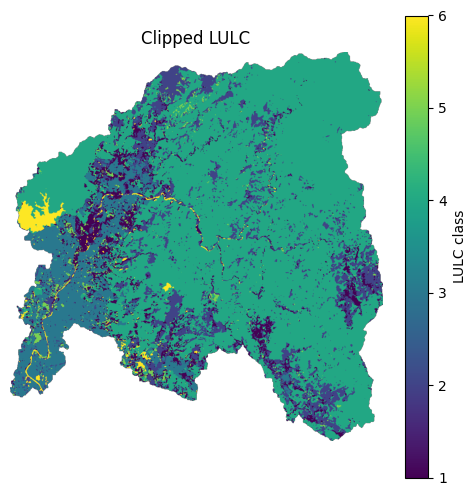

In [77]:
from scipy.ndimage import generic_filter

def max_voting_filter(array):
    def max_vote(values):
        values = values[~np.isnan(values)]
        if len(values) == 0:
            return np.nan
        return np.bincount(values.astype(int)).argmax()
    return generic_filter(array,max_vote,size = 3, mode = 'constant', cval = np.nan)


lulc_cleaned = max_voting_filter(lulc_clipped)

import matplotlib.pyplot as plt

plt.figure(figsize=(6, 6))
plt.imshow(lulc_cleaned)
plt.colorbar(label="LULC class")
plt.title("Clipped LULC")
plt.axis("off")
plt.show()




In [78]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, clf.predict(X_test))
reverse_map = {v: k for k, v in mapping.items()}
print(cm)

[[ 262   54    2    7    4    3]
 [  38  718   12    8    3    4]
 [   0   30  235    2    0    0]
 [   2    5    0 1404    5    4]
 [  18   37    0    7   80    0]
 [  12   11    1    8    0  269]]


In [79]:
print(classification_report(y_test,clf.predict(X_test)))

              precision    recall  f1-score   support

         1.0       0.79      0.79      0.79       332
         2.0       0.84      0.92      0.88       783
         3.0       0.94      0.88      0.91       267
         4.0       0.98      0.99      0.98      1420
         5.0       0.87      0.56      0.68       142
         6.0       0.96      0.89      0.93       301

    accuracy                           0.91      3245
   macro avg       0.90      0.84      0.86      3245
weighted avg       0.92      0.91      0.91      3245

